In [1]:
import warnings
warnings.filterwarnings('ignore')

# data analysis
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from shapely.wkt import loads

# data visualisation
from mapboxgl.utils import create_color_stops, create_weight_stops
from mapboxgl.viz import ChoroplethViz, CircleViz, HeatmapViz
from jenkspy import jenks_breaks
import matplotlib.pyplot as plt

# sql
import psycopg2 as pg
import pandas.io.sql as psql

# misc
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### NYC Yellow Taxi data test task

Let's take a first glance at the data:

In [2]:
! wc -l yellow_tripdata_2015.csv

 69006888 yellow_tripdata_2015.csv


In [3]:
! head yellow_tripdata_2015.csv

,tpep_pickup_datetime,pickup_longitude,pickup_latitude
0,2015-07-01 00:00:00,-73.99415588378906,40.75112533569336
1,2015-07-01 00:00:00,-73.98465728759766,40.76848602294922
2,2015-07-01 00:00:00,-73.97888946533203,40.76228713989258
3,2015-07-01 00:00:00,-73.99279022216798,40.742759704589844
4,2015-07-01 00:00:00,-73.9124298095703,40.76980972290039
5,2015-07-01 00:00:00,-73.95915985107422,40.77342987060547
6,2015-07-01 00:00:00,-73.78945922851562,40.64725875854492
7,2015-07-01 00:00:00,0.0,0.0
8,2015-07-01 00:00:00,-73.99893188476562,40.74467849731445


We can already see that data contains invalid coordinates (0,0). Let's map a small sample of points to get some basic idea about spatial distribution.

In [4]:
df = pd.read_csv('yellow_tripdata_2015.csv', nrows=10000)

In [5]:
# filter invalid geometries
df = df[df['pickup_longitude'] < -70.0].reset_index(drop=True)

# make GeoDataFrame with shapely geometries
df['geometry'] = [Point(x,y) for x,y in zip(df['pickup_longitude'], df['pickup_latitude'])] 
df = gpd.GeoDataFrame(df)

# export data to geojson to use with mapbox
with open('sample_pnts.geojson','w') as f:
    f.write(df.to_json())

In [6]:
df.head(2)

,Unnamed: 0,tpep_pickup_datetime,pickup_longitude,pickup_latitude,geometry
0,0,2015-07-01 00:00:00,-73.994156,40.751125,POINT (-73.99415588378906 40.75112533569336)
1,1,2015-07-01 00:00:00,-73.984657,40.768486,POINT (-73.98465728759766 40.76848602294922)


In [8]:
# mapbox access token
token = 'pk.eyJ1IjoidXNiaWtlbGFuZXMiLCJhIjoiY2puazZ0ZjV6MTB3MjNycjd1aGQ3MHlrNyJ9.3-bO0MoKnAA3RqLZcjsAZg'

# creating parameters for a heatmap
color_stops = [0.01,0.25,0.5,0.75,1]
heatmap_color_stops = create_color_stops(color_stops, colors='RdPu')
heatmap_radius_stops = [[0,0.5], [1, 3]] #increase radius with zoom
heatmap_weight_stops = create_weight_stops(color_stops)

#Create a heatmap
viz = HeatmapViz('sample_pnts.geojson',
                  access_token=token,
                  weight_property='count',
                  weight_stops=heatmap_weight_stops,
                  color_stops=heatmap_color_stops,
                  radius_stops=heatmap_radius_stops,
                  opacity=0.9,
                  center = MultiPoint(df['geometry'].tolist()).centroid.coords[0],
                  zoom=11,
                  below_layer='waterway-label')
viz.show()

We can already see that taxi trips are mostly concentrated in Manhattan and airports.

#### Trip statistics by zone

For this part I took official taxi zones used by the City of New York from [the official NYC webcite](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) (I changed the coordinate system to Lat/Lon WGS 84 to match the trip data).

In [9]:
zones = gpd.read_file('taxi_zones.geojson')
zones.head(2)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"(POLYGON ((-74.184453 40.6949959999999, -74.18..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260664 40.6389870471767...


Intersecting big amounts of point data with complex shaped polygons takes a lot of computation, so I needed to chunk the dataset.  
  
Using a regular rectangular fishnet could have decreased the computation but using official taxi zones seemed more elegant to me.

In [2]:
zones = gpd.read_file('taxi_zones.geojson')
zones = zones[['OBJECTID', 'zone', 'geometry']]
zones['count'] = 0

# the optimal chunk size was found empirically based on tqdm's estimations
chunksize = 100000

for df in tqdm(pd.read_csv('yellow_tripdata_2015.csv', chunksize=chunksize, usecols=['pickup_longitude', 'pickup_latitude']), total=round(69006888/chunksize)):
    
    # transforming data to geodataframe, setting a projection
    df['geometry'] = [Point(x,y) for x,y in zip(df['pickup_longitude'], df['pickup_latitude'])]
    df = df.drop(columns=['pickup_longitude','pickup_latitude'])
    df = gpd.GeoDataFrame(df)
    df.crs = {'init': 'epsg:4326'}
    
    # joining trips and zones spatially, counting points in each zone
    sp_joined = gpd.sjoin(
    df, zones, how='left').groupby('OBJECTID', as_index=False).count()[['OBJECTID', 'index_right']]
    sp_joined = sp_joined.rename(columns={'index_right':'count'})
    zones = pd.merge(zones, sp_joined, on='OBJECTID', how='outer')
    
    # a little hacky way to store trip counts over iterations
    zones = zones.fillna(0)
    zones['count'] = zones['count_y'] + zones['count_x']
    zones = zones[['OBJECTID', 'zone', 'count', 'geometry']]
    
del df

This process took approx. 2 hours (while waiting I implemented a database-based way to process data, that I'll show later this notebook)

In [13]:
# export data to geojson
#with open('zones_with_counts.geojson','w') as f:
#    f.write(zones.to_json(ensure_ascii=False))

In [11]:
zones = gpd.read_file('zones_with_counts.geojson')

In [14]:
print(str(round(((
    69006888 - zones['count'].sum()) / 69006888), 3) * 100)+ '% of data is filtered due to invalid coordinates')

1.5% of data is filtered due to invalid coordinates


In [15]:
zones.head(2)

,id,OBJECTID,count,zone,geometry
0,0,1,4607.0,Newark Airport,"(POLYGON ((-74.184453 40.6949959999999, -74.18..."
1,1,2,40.0,Jamaica Bay,(POLYGON ((-73.82337597260664 40.6389870471767...


Let's make a choropleth map (you can find a more sophisticated web version of the visualisation [here](google.com))

In [16]:
color_breaks = jenks_breaks(zones['count'], nb_class=5)
color_stops = create_color_stops(color_breaks, colors='YlOrRd')

viz = ChoroplethViz('zones_with_counts.geojson',
                    line_width = 0.8,
                access_token=token,
                height='400px',
                color_property = "count",
                color_stops = color_stops,
                center = (-73.97, 40.74),
                zoom = 10,
                opacity=0.6,
                below_layer = 'waterway-label'
              )
viz.show()

In [17]:
zones.sort_values(by='count', ascending=False).head()

,id,OBJECTID,count,zone,geometry
236,236,237,2500998.0,Upper East Side South,(POLYGON ((-73.96612747299991 40.7621792999999...
160,160,161,2408518.0,Midtown Center,(POLYGON ((-73.97534377999995 40.7552996949999...
185,185,186,2298132.0,Penn Station/Madison Sq West,(POLYGON ((-73.99096832799997 40.7454208899998...
78,78,79,2277173.0,East Village,(POLYGON ((-73.98377990999992 40.7215359539999...
233,233,234,2262147.0,Union Sq,(POLYGON ((-73.9899693639999 40.73490456699995...


In [24]:
my_zone = zones.sort_values(by='count', ascending=False).reset_index(drop=True)['geometry'][0]
my_zone_bbox = my_zone.bounds

In [25]:
chunksize = 100000
in_my_zone = pd.DataFrame()

for df in tqdm(pd.read_csv('yellow_tripdata_2015.csv', chunksize=chunksize, usecols=['tpep_pickup_datetime','pickup_longitude', 'pickup_latitude']), total=round(69006888/chunksize)):
    
    df = df[
        (df['pickup_longitude'] > my_zone_bbox[0])
        &(df['pickup_longitude'] < my_zone_bbox[2])
        &(df['pickup_latitude'] > my_zone_bbox[1])
        &(df['pickup_latitude'] < my_zone_bbox[3])
    ].reset_index(drop=True)
    
    in_my_zone = pd.concat([in_my_zone, df], ignore_index=True)
    #break

In [26]:
in_my_zone['geometry'] = [Point(x,y) for x,y in zip(in_my_zone['pickup_longitude'], in_my_zone['pickup_latitude'])]
in_my_zone = in_my_zone[['tpep_pickup_datetime', 'geometry']]
in_my_zone = gpd.GeoDataFrame(in_my_zone)

Intersecting the rest of the points with the actual polygon to discard unwanted ones. This can be done without a loop with ```points.intersection(polygon)```, but with this amount of data I want to know estimated time

In [27]:
len(in_my_zone)

4250493

In [28]:
bool_filter = []
for x in tqdm(range(len(in_my_zone))):
    bool_filter.append(in_my_zone['geometry'][x].intersects(my_zone))

In [29]:
in_my_zone = in_my_zone[bool_filter].reset_index(drop=True)
in_my_zone['id'] = range(len(in_my_zone))
len(in_my_zone)

2500998

In [22]:
#with open('trips_needed.geojson','w') as f:
    f.write(in_my_zone.to_json())

In [32]:
#in_my_zone = gpd.read_file('trips_needed.geojson')

In [33]:
in_my_zone.head(2)

,id,tpep_pickup_datetime,geometry
0,0,2015-07-01T00:00:00,POINT (-73.96221923828125 40.77333831787109)
1,1,2015-07-01T00:00:07,POINT (-73.96724700927734 40.76663208007813)


In [34]:
in_my_zone['tpep_pickup_datetime'] = pd.to_datetime(in_my_zone['tpep_pickup_datetime'])
in_my_zone['tpep_pickup_datetime_new'] = in_my_zone['tpep_pickup_datetime'].dt.round('1H')  
data_agg = in_my_zone.groupby(by='tpep_pickup_datetime_new').count()[['id']]
data_agg = data_agg.rename(columns={'id':'trip_count'})
del in_my_zone

In [35]:
data_agg.head(3)

,trip_count
tpep_pickup_datetime_new,
2015-07-01 00:00:00,117
2015-07-01 01:00:00,146
2015-07-01 02:00:00,67


### SQL way to do this

https://github.com/andreytyu/taxi-test/blob/master/taxi-test/sql

In [36]:
connection = pg.connect(
        host='localhost',
        port='9900', dbname='postgres', 
        user='postgres',
        password='password') 
zones_agg = psql.read_sql_query(
        """select zone_id, zone_name, count, st_astext(geom) as geom from zones_agg""",
        connection)
hour_agg = psql.read_sql_query(
        """select * from hour_agg""",
        connection)
connection.close() 

In [37]:
hour_agg.index = pd.DatetimeIndex(hour_agg.dt)
hour_agg = hour_agg.drop('dt', axis=1)
hour_agg.head(2)

,count
dt,
2015-07-01 00:00:00,509
2015-07-01 01:00:00,253


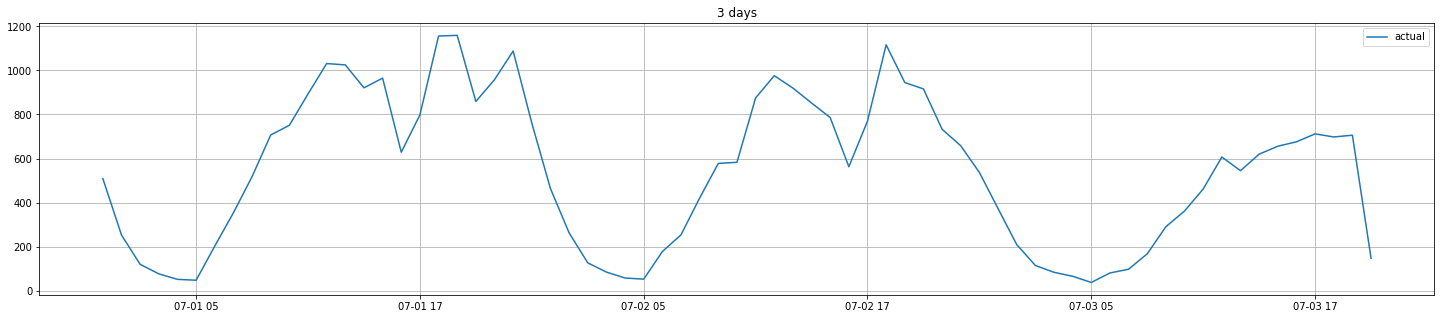

In [39]:
plt.figure(figsize=(25, 5))
plt.plot(hour_agg['count'], label="actual")
plt.legend(loc="best")
plt.title("3 days")
plt.grid(True)

In [41]:
zones_agg.sort_values(by='count', ascending=False).head(2)

,zone_id,zone_name,count,geom
170,161.0,Midtown Center,37262,MULTIPOLYGON(((-73.9753437799999 40.7552996949...
239,237.0,Upper East Side South,34471,MULTIPOLYGON(((-73.9661274729999 40.7621792999...


In [42]:
# converting geometries from Well-Known Text, exporting geojson
zones_agg['geometry'] = [loads(x) for x in zones_agg['geom']]
zones_agg = zones_agg.drop('geom', axis=1)
zones_agg = gpd.GeoDataFrame(zones_agg)
with open('zones_agg_from_sql.geojson','w') as f:
    f.write(zones_agg.to_json())

In [43]:
color_breaks = jenks_breaks(zones_agg['count'], nb_class=5)
color_stops = create_color_stops(color_breaks, colors='YlOrRd')

viz = ChoroplethViz('zones_agg_from_sql.geojson',
                    line_width = 0.8,
                access_token=token,
                height='400px',
                color_property = "count",
                color_stops = color_stops,
                center = (-73.97, 40.74),
                zoom = 10,
                opacity=0.6,
                below_layer = 'waterway-label'
              )
viz.show()

### UNDER CONSTRUCTION BELOW

In [616]:
def predict_one_hour_forward(series):
    actual = series.drop(index=series.index[0])
    prediction = series.shift(1).dropna()
    return actual, prediction

In [634]:
base_actual, base_prediction = predict_one_hour_forward(data_agg.trip_count)

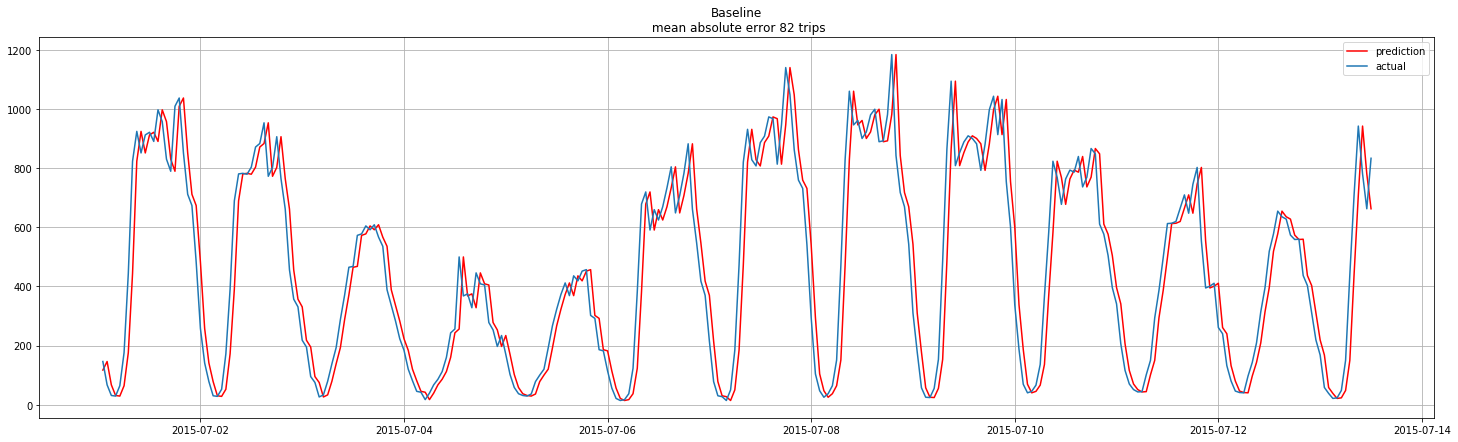

In [647]:
plt.figure(figsize=(25, 7))
plt.plot(base_prediction[:300], "r", label="prediction")
plt.plot(base_actual[:300], label="actual")
plt.legend(loc="best")
plt.title("Baseline\n mean absolute error %i trips"%(int(median_absolute_error(base_actual, base_prediction))))
plt.grid(True)

In [419]:
from sklearn.metrics import accuracy_score, mean_squared_log_error, r2_score, mean_squared_error, median_absolute_error

In [195]:
mean_squared_log_error(test['id'][1:], test['shifted'][1:])

0.21878588196435908

In [90]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [196]:
r2_score(test['id'][1:], test['shifted'][1:])

0.827726521320931

In [439]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    #data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    #data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    #data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [440]:
X_train.head(2)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,is_weekend,weekday_average,hour_average
0,852.0,925.0,824.0,444.0,176.0,64.0,29.0,31.0,67.0,146.0,117.0,0,662.305556,750.903614
1,913.0,852.0,925.0,824.0,444.0,176.0,64.0,29.0,31.0,67.0,146.0,0,662.305556,830.957831


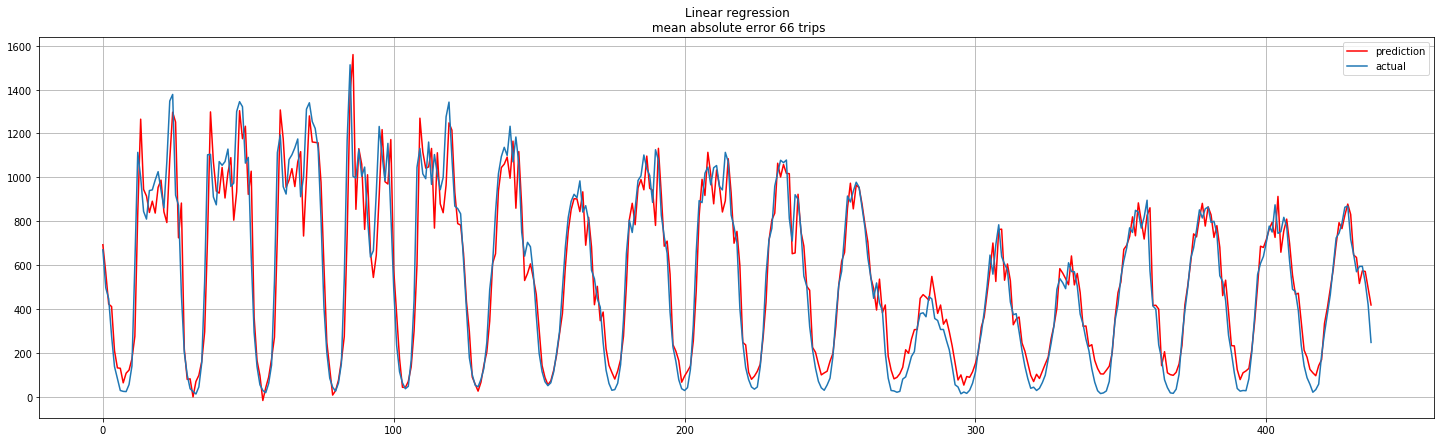

In [648]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(test.trip_count, test_size=0.1, lag_start=1, lag_end=6)
lr = LinearRegression().fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(25, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n mean absolute error {} trips".format(int(median_absolute_error(prediction, y_test))))
plt.grid(True)

In [395]:
mean_squared_log_error(np.array([int(x) for x in prediction]), np.array([int(y) for y in y_test.tolist()]))

/usr/local/lib/python3.6/site-packages/sklearn/metrics/regression.py:314: RuntimeWarning:

invalid value encountered in log



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [404]:
np.isfinite(y_test.tolist()).all()

True

In [406]:
np.isfinite(prediction).all()

True

In [408]:
np.isnan(prediction).all()

False

In [409]:
np.isnan(y_test.tolist()).all()

False

In [388]:
len(y_test.dropna().tolist())

431

In [389]:
len(prediction)

431

In [116]:
import numpy as np

In [117]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [118]:
%%time
performTimeSeriesCV(X_train, y_train, 5, lr, r2_score)

Size train set: (3092, 39)
Size of each fold: 618

Splitting the first 2 chunks at 1/2
Size of train + test: (1236, 39)

Splitting the first 3 chunks at 2/3
Size of train + test: (1854, 39)

Splitting the first 4 chunks at 3/4
Size of train + test: (2472, 39)

Splitting the first 5 chunks at 4/5
Size of train + test: (3090, 39)
CPU times: user 24.6 ms, sys: 5.77 ms, total: 30.4 ms
Wall time: 24 ms


0.8526386836680879

In [436]:
import xgboost as xgb

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(test[['id']], lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].idxmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].idxmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(20, 10))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    #lower = prediction_test-scale*deviation
    #upper = prediction_test+scale*deviation

    #Anomalies = np.array([np.NaN]*len(y_test))
    #Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(20, 10))
    plt.plot(prediction_test, label="prediction")
    #plt.plot(lower, "r--", label="upper bond / lower bond")
    #plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    #plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost mean absolute error {} trips".format(int(median_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

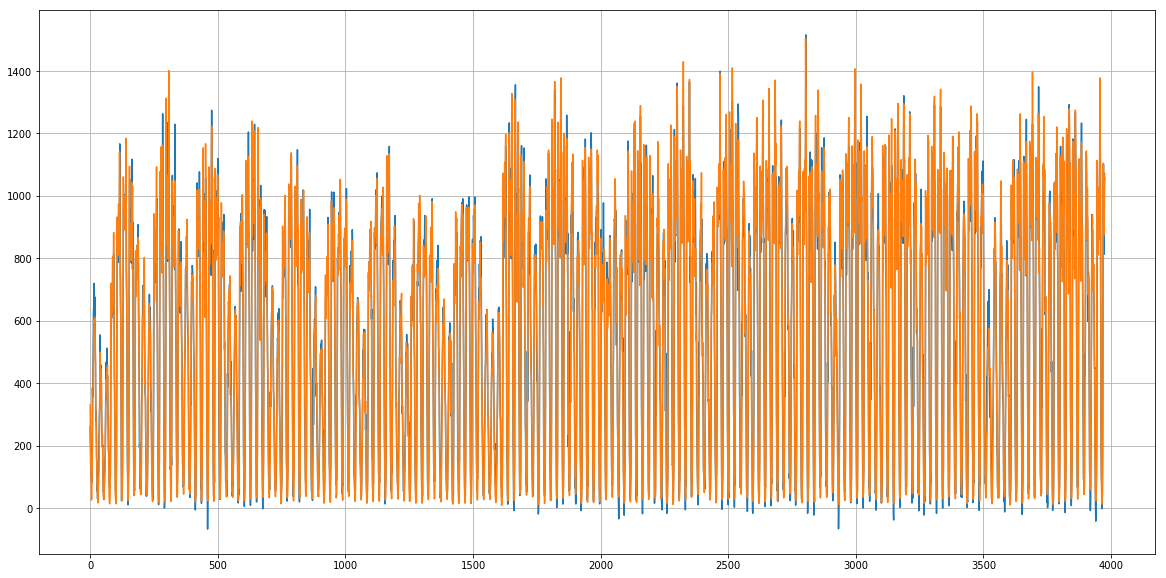

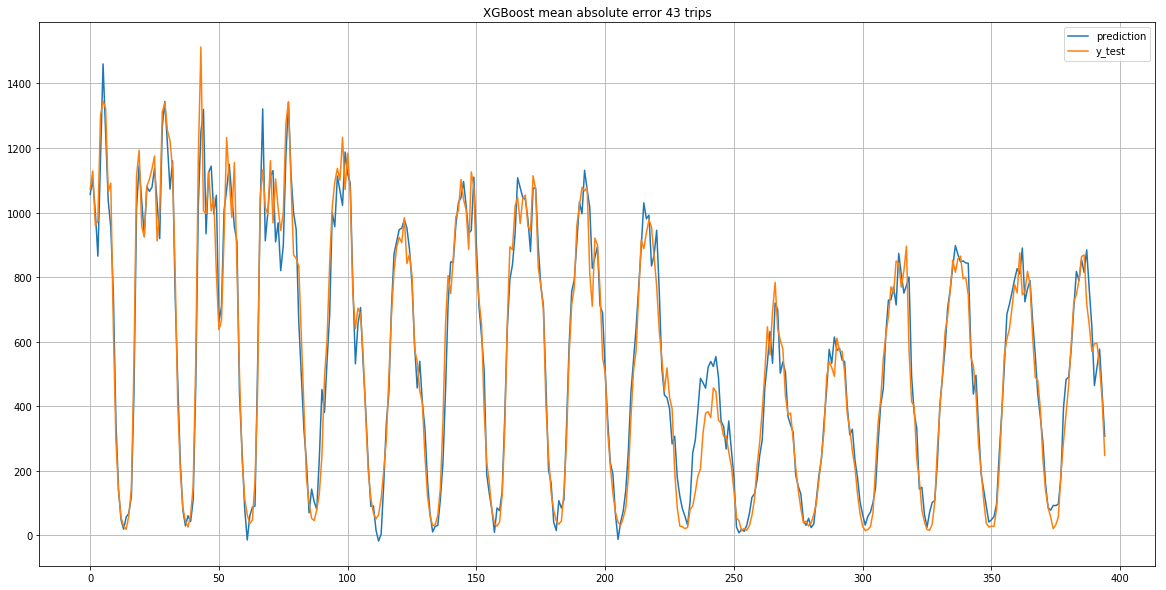

In [442]:
XGB_forecast(test[['id']], test_size=0.1, lag_start=1, lag_end=48)

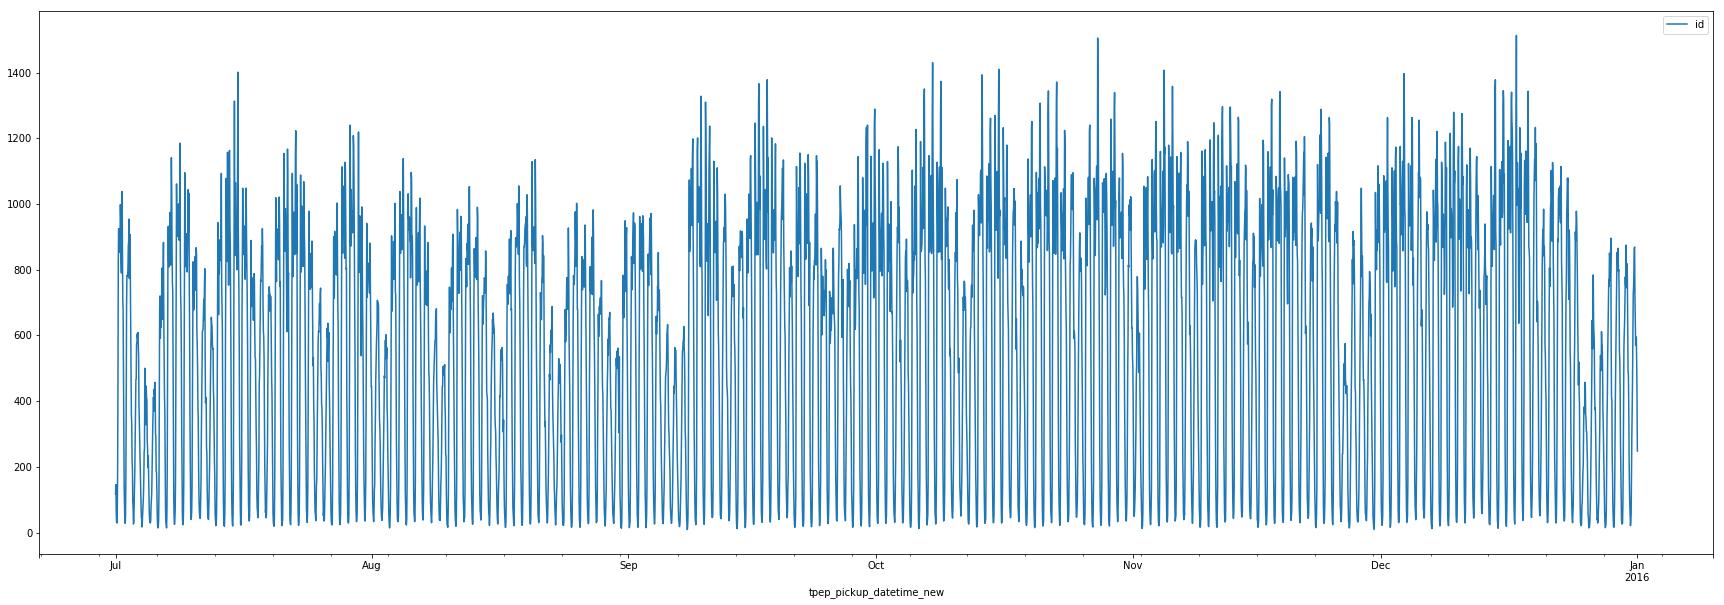

In [62]:
test.plot(figsize=(30,10))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).mean()



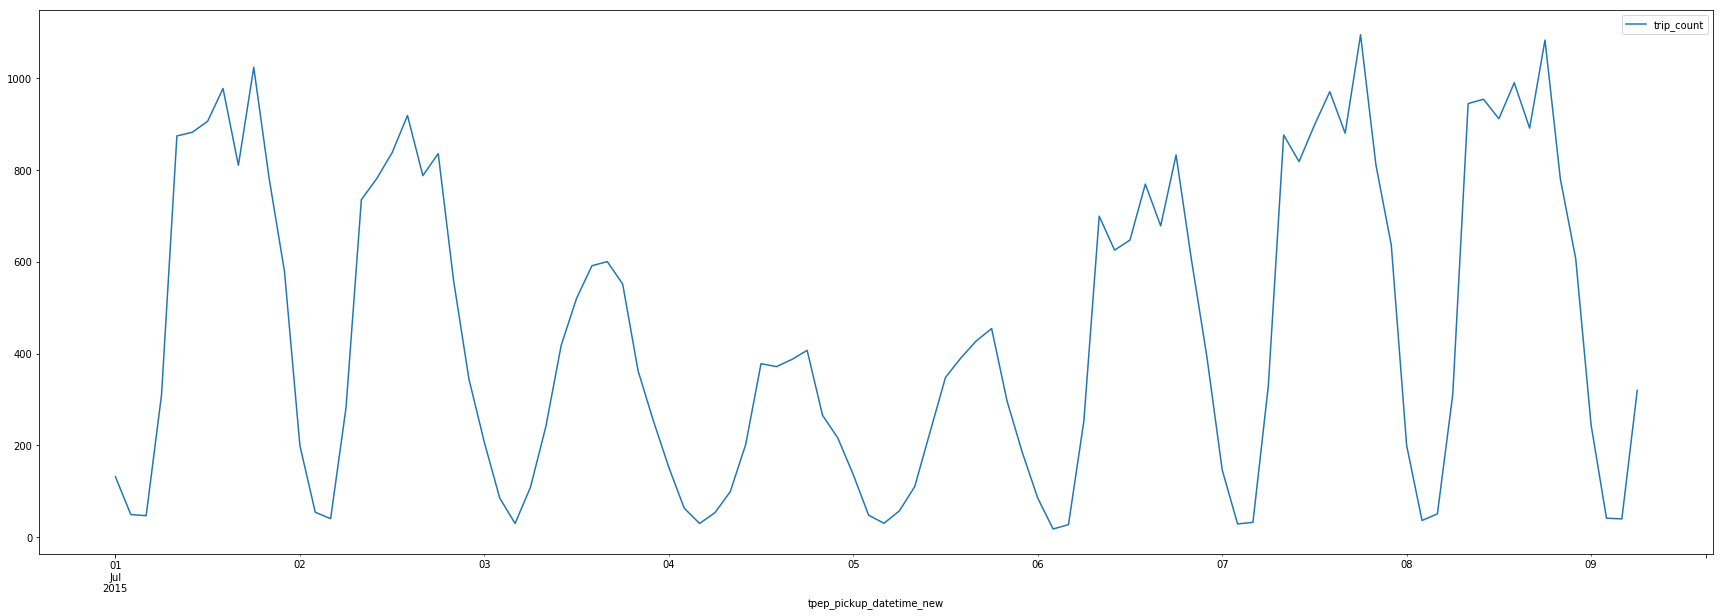

In [661]:
test.resample('2H', how='mean')[:100].plot(figsize=(30,10))

In [48]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(test[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

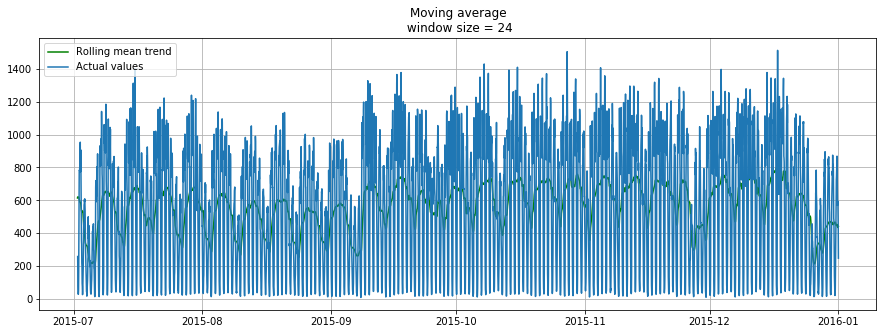

In [52]:
plotMovingAverage(test, 24)

In [56]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

#df = pd.read_csv(
#    'yellow_tripdata_2015.csv',
#    nrows=10000,
#    index_col=['tpep_pickup_datetime'],
#    parse_dates=['tpep_pickup_datetime'])
plotly_df(test[:200], title = "Taxi trips from Upper East Side South")
plotly_df(test[:200], title = "Taxi trips from Upper East Side South")